# Update packages and Tools

In [1]:
!pip install spicy --upgrade

In [2]:
!pip install numba --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


In [3]:
!pip install numpy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


In [1]:
!pip install gensim --upgrade

Importing Necesaary Packages & Libraries

# 1.0 Necessary Libraries and Dataset

In [5]:
#Import resource from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Import necessary Libraries Dtasets

In [2]:
import pandas as pd


# Natural Language Tookit

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

# Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Scikit-learn

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Some necessary packages
import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime



[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## 1.2 Importing Dataset

In [3]:
#Import the dataset from the Google Drive
twitter_data = pd.read_csv('drive/MyDrive/Colab Notebooks/Twitter_Data.csv')
twitter_data1 = twitter_data
# Print the first five sentence
twitter_data.head(8)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0


In [4]:
#Remove neutral comments in order to perform analysis to Negative and positive sentiment
twitter_data  = twitter_data[twitter_data.category != 0.0]

In [5]:
#Duplicated Label Removal
twitter_data.drop_duplicates()
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107767 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107765 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


# 2 Data Pre-pocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords, wordnet
import matplotlib.pyplot as plt
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2.1 Variables for Data- Prepocessing

In [7]:
# Varaible for the dataset
ColumnOfData = ["clean_text", "category"]
EncodingData = "ISO-8859-1"
SizeOfTraining = 0.8


POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
Sentment_Thresholds = (0.4, 0.7)


## 2.2 Find the Values that are null

In [8]:
# Confirming presence of missing values in each variables
def drop_null_rows(data):
    print("Before dropping null rows:")
    print(data.isnull().sum())

#Delete rows that are small and will not affect overal modelling
    data.dropna(how='any', inplace=True)
    print("After dropping null rows:")
    print(data.isnull().sum())

drop_null_rows(twitter_data)


Before dropping null rows:
clean_text    2
category      7
dtype: int64
After dropping null rows:
clean_text    0
category      0
dtype: int64


<ipython-input-8-70c3da33fb71>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(how='any', inplace=True)


In [9]:
# Delete the positive label and keep the balance between positive and negative
twitter_data = pd.DataFrame(twitter_data)
n_rows = len(twitter_data.index)
n_delete = int(n_rows / 2.94)
twitter_data = twitter_data.drop(twitter_data[twitter_data['category'] == 1.0].sample(n=n_delete).index)


## 2.3 Encode the label and Distribution of Dataset Labels

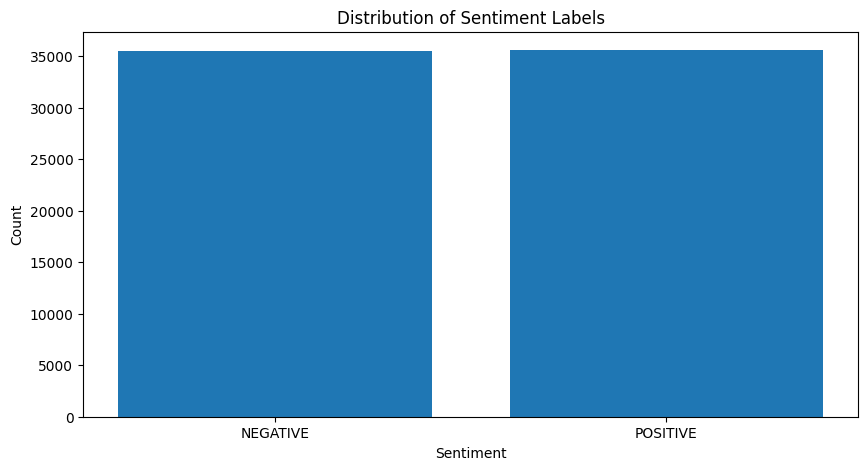

In [10]:
def visualize_sentiment_distribution(data, label_mapping):
    def encode_sentiment_label(label):
        return label_mapping[int(label)]

    data.category = data.category.apply(lambda x: encode_sentiment_label(x))

    label_counts = Counter(data.category)

    plt.figure(figsize=(10, 5))
    plt.bar(label_mapping.values(), label_counts.values())
    plt.title("Distribution of Sentiment Labels")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

label_mapping = {-1.0: "NEGATIVE", 1.0: "POSITIVE"}
visualize_sentiment_distribution(twitter_data, label_mapping)


## 2.4 Text Cleaning and Structuring

### Remove URLs, HTML tags and entities


In [11]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags and entities
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+', '', text)
    return text

# Apply the preprocessing function to the 'clean_text' column
twitter_data['mod_text'] = twitter_data['clean_text'].apply(preprocess_text)

### Remove emoticons, special symbols, punctuation and non-alphanumeric characters

In [12]:
def preprocess_text(text):
    # Remove emoticons and special symbols
    emo_pattern = r'[' + u'\U0001F600-\U0001F64F' + u'\U0001F300-\U0001F5FF' + u'\U0001F680-\U0001F6FF' + \
                  u'\U0001F1E0-\U0001F1FF' + u'\U00002702-\U000027B0' + u'\U000024C2-\U0001F251' + ']+'
    text = re.sub(emo_pattern, '', text, flags=re.UNICODE)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove non-alphanumeric characters
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)

    return text

# Apply the preprocessing function to the 'clean_text' column
twitter_data['mod_text'] = twitter_data['clean_text'].apply(preprocess_text)
twitter_data.head()


,clean_text,category,mod_text
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...
11,hope tuthukudi people would prefer honest well...,POSITIVE,hope tuthukudi people would prefer honest well...
15,vote such party and leadershipwho can take fas...,NEGATIVE,vote such party and leadershipwho can take fas...
19,didn’ write chowkidar does mean ’ anti modi tr...,NEGATIVE,didn write chowkidar does mean anti modi try ...


### Tokenizing the tweet test

In [13]:
def tokenize_text(text):
    return word_tokenize(text)

# Apply the tokenization function to the 'mod_text' column
twitter_data['tokenized'] = twitter_data['mod_text'].apply(tokenize_text)
twitter_data.head()


,clean_text,category,mod_text,tokenized
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t..."
11,hope tuthukudi people would prefer honest well...,POSITIVE,hope tuthukudi people would prefer honest well...,"[hope, tuthukudi, people, would, prefer, hones..."
15,vote such party and leadershipwho can take fas...,NEGATIVE,vote such party and leadershipwho can take fas...,"[vote, such, party, and, leadershipwho, can, t..."
19,didn’ write chowkidar does mean ’ anti modi tr...,NEGATIVE,didn write chowkidar does mean anti modi try ...,"[didn, write, chowkidar, does, mean, anti, mod..."


### Lower words of all the text

In [14]:
# Lower words of all the text
def convert_to_lower(token_list):
    return [word.lower() for word in token_list]

# Apply the convert_to_lower function to the 'tokenized' column
twitter_data['lower'] = twitter_data['tokenized'].apply(convert_to_lower)


### Remove Stopwords

In [15]:
def setup_nltk():
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')

    stopwords_list = set(stopwords.words("english"))
    stopwords_list.remove('not')
    additional_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords_list = stopwords_list.union(additional_stopwords)
    stemmer = SnowballStemmer("english")

    return stopwords_list, stemmer

stopwords_list, stemmer = setup_nltk()


def remove_stopwords(token_list):
    return [word for word in token_list if word not in stopwords_list]

# Apply the remove_stopwords function to the 'lower' column
twitter_data['stopwords_removed'] = twitter_data['lower'].apply(remove_stopwords)

# Display the updated DataFrame
twitter_data.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,clean_text,category,mod_text,tokenized,lower,stopwords_removed
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,..."
11,hope tuthukudi people would prefer honest well...,POSITIVE,hope tuthukudi people would prefer honest well...,"[hope, tuthukudi, people, would, prefer, hones...","[hope, tuthukudi, people, would, prefer, hones...","[hope, tuthukudi, people, would, prefer, hones..."
15,vote such party and leadershipwho can take fas...,NEGATIVE,vote such party and leadershipwho can take fas...,"[vote, such, party, and, leadershipwho, can, t...","[vote, such, party, and, leadershipwho, can, t...","[vote, party, leadershipwho, take, fast, firm,..."
19,didn’ write chowkidar does mean ’ anti modi tr...,NEGATIVE,didn write chowkidar does mean anti modi try ...,"[didn, write, chowkidar, does, mean, anti, mod...","[didn, write, chowkidar, does, mean, anti, mod...","[write, chowkidar, mean, anti, modi, try, visi..."


### Using Part_of_speech(POS) Tagging

In [16]:
def get_pos_tags(token_list):
    return nltk.tag.pos_tag(token_list)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Apply the get_pos_tags function to the 'stopwords_removed' column
twitter_data['pos_tags'] = twitter_data['stopwords_removed'].apply(get_pos_tags)

# Apply the get_wordnet_pos function to the 'pos_tags' column
twitter_data['wordnet_pos'] = twitter_data['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

# Display the updated DataFrame
twitter_data.head()



,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c..."
11,hope tuthukudi people would prefer honest well...,POSITIVE,hope tuthukudi people would prefer honest well...,"[hope, tuthukudi, people, would, prefer, hones...","[hope, tuthukudi, people, would, prefer, hones...","[hope, tuthukudi, people, would, prefer, hones...","[(hope, NN), (tuthukudi, NN), (people, NNS), (...","[(hope, n), (tuthukudi, n), (people, n), (woul..."
15,vote such party and leadershipwho can take fas...,NEGATIVE,vote such party and leadershipwho can take fas...,"[vote, such, party, and, leadershipwho, can, t...","[vote, such, party, and, leadershipwho, can, t...","[vote, party, leadershipwho, take, fast, firm,...","[(vote, NN), (party, NN), (leadershipwho, JJ),...","[(vote, n), (party, n), (leadershipwho, a), (t..."
19,didn’ write chowkidar does mean ’ anti modi tr...,NEGATIVE,didn write chowkidar does mean anti modi try ...,"[didn, write, chowkidar, does, mean, anti, mod...","[didn, write, chowkidar, does, mean, anti, mod...","[write, chowkidar, mean, anti, modi, try, visi...","[(write, JJ), (chowkidar, NN), (mean, NN), (an...","[(write, a), (chowkidar, n), (mean, n), (anti,..."


### Using lemmatizer.

In [17]:
# Create an instance of WordNetLemmatizer
wordNetLem = WordNetLemmatizer()

# Define a function to perform lemmatization and remove stopwords
def lemmatize_and_remove_stopwords(tagged_words):
    # Lemmatize the words using part-of-speech tags and WordNetLemmatizer
    lemmatized_words = [wordNetLem.lemmatize(word, tag) for word, tag in tagged_words]
    # Remove stopwords
    non_stopwords = [word for word in lemmatized_words if word not in stopwords_list]
    return non_stopwords

# Apply lemmatization and stopwords removal using 'wordnet_pos' column
twitter_data['lemmatized'] = twitter_data['wordnet_pos'].apply(lemmatize_and_remove_stopwords)
# Join the processed words into a string
twitter_data['lemma_str'] = [' '.join(map(str, l)) for l in twitter_data['lemmatized']]

print("Total Rows =", len(twitter_data.clean_text))

twitter_data.head()


Total Rows = 71106


,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
11,hope tuthukudi people would prefer honest well...,POSITIVE,hope tuthukudi people would prefer honest well...,"[hope, tuthukudi, people, would, prefer, hones...","[hope, tuthukudi, people, would, prefer, hones...","[hope, tuthukudi, people, would, prefer, hones...","[(hope, NN), (tuthukudi, NN), (people, NNS), (...","[(hope, n), (tuthukudi, n), (people, n), (woul...","[hope, tuthukudi, people, would, prefer, hones...",hope tuthukudi people would prefer honest well...
15,vote such party and leadershipwho can take fas...,NEGATIVE,vote such party and leadershipwho can take fas...,"[vote, such, party, and, leadershipwho, can, t...","[vote, such, party, and, leadershipwho, can, t...","[vote, party, leadershipwho, take, fast, firm,...","[(vote, NN), (party, NN), (leadershipwho, JJ),...","[(vote, n), (party, n), (leadershipwho, a), (t...","[vote, party, leadershipwho, take, fast, firm,...",vote party leadershipwho take fast firm action...
19,didn’ write chowkidar does mean ’ anti modi tr...,NEGATIVE,didn write chowkidar does mean anti modi try ...,"[didn, write, chowkidar, does, mean, anti, mod...","[didn, write, chowkidar, does, mean, anti, mod...","[write, chowkidar, mean, anti, modi, try, visi...","[(write, JJ), (chowkidar, NN), (mean, NN), (an...","[(write, a), (chowkidar, n), (mean, n), (anti,...","[write, chowkidar, mean, anti, modi, try, visi...",write chowkidar mean anti modi try visit plz n...


## 2.5 Split the Train and Test dataset

In [18]:
twitter_data_new = twitter_data[["lemma_str", "category"]]
twitter_data_train, twitter_data_test = train_test_split(twitter_data_new, test_size=1 - SizeOfTraining, random_state=42)

print("TRAIN DATASET SIZE:", len(twitter_data_train))
print("TEST DATASET SIZE:", len(twitter_data_test))

twitter_data_train.head(), twitter_data_test.head()


TRAIN DATASET SIZE: 56884
TEST DATASET SIZE: 14222


(                                               lemma_str  category
 84670  isnt bribe name crime source money must take a...  POSITIVE
 60258  modi bjps case deliberately delay action keep ...  POSITIVE
 79     kitna jalte tum modi tweet show jealousy towar...  POSITIVE
 71044  accompany honble rajya sabha shshamsher singh ...  POSITIVE
 38162  mooh main ghee shakkar indeed modi hasthrough ...  NEGATIVE,
                                                 lemma_str  category
 51141   must think modi go impose emergacy sir imaanda...  POSITIVE
 117537  question modi doesnt take call secular journal...  NEGATIVE
 115429  people first try learn jalanarth jalankhor jam...  POSITIVE
 64655                      modi single handley alwa madam  NEGATIVE
 117963                          really pakistan want read  POSITIVE)

##2.6 Dataset Word Cloud Analysis

In [19]:
# Packages for WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict


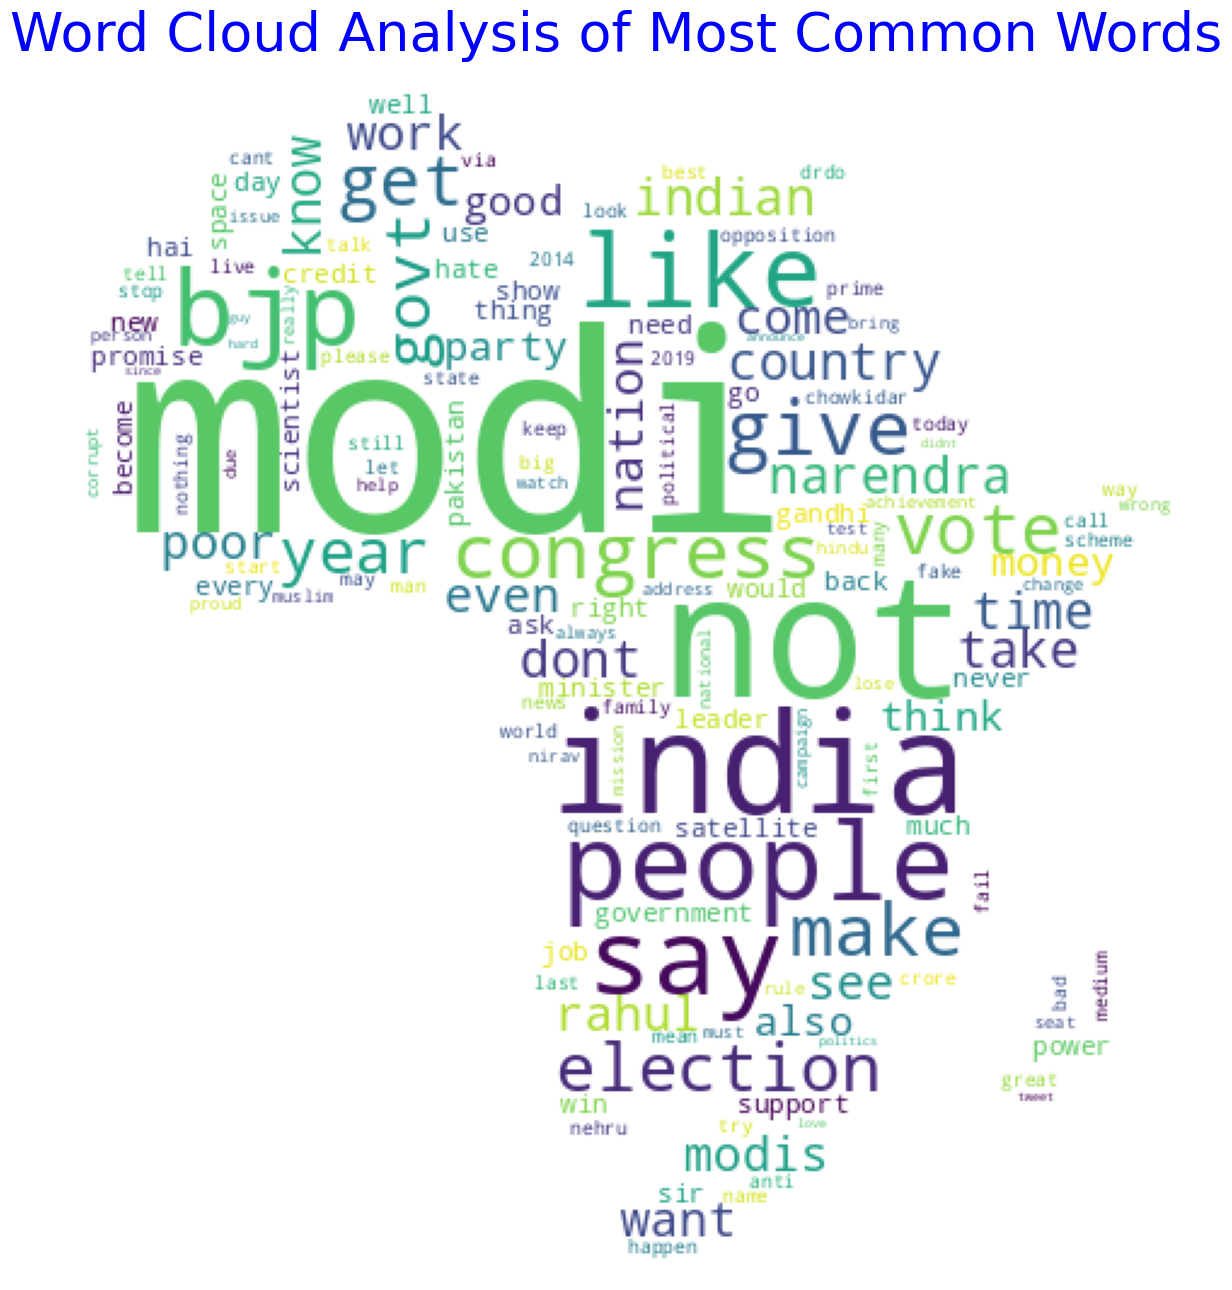

In [20]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.probability import FreqDist

def plot_wordcloud(words, mask, title, title_size, figure_size=(18.0, 13.0), image_color=False):
    all_words = [word for wordlist in words for word in wordlist]
    most_common = FreqDist(all_words).most_common(150)
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=150,
        max_font_size=115,
        random_state=42,
        mask=mask,
    ).generate_from_frequencies(dict(most_common))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'blue', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()
#Applay the mask from the Google Drive
comments_mask = np.array(Image.open('drive/MyDrive/Colab Notebooks/mask.webp'))
plot_wordcloud(twitter_data['lemmatized'], comments_mask,
               'Word Cloud Analysis of Most Common Words',
               title_size=39)



# 3: Use Word2Vec for dataset nalysis

In [21]:
# Import Word2vec Package
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

#  Parameter of  Word2Vec Training
SizeOfW2V = 300
WindowOfW2V = 5
EpochOfW2V = 32
MinCountOfW2V = 10

## Create Corpus，Word2Vec Model and also create Vocab, Finally Train and Test Word2Vec Model

In [22]:

from gensim.models import Word2Vec
global  model_Word2Vec
def train_word2vec_model(documents, vector_size, window, min_count, workers, sg):
    model = Word2Vec(sentences=documents, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)
    # Train your Word2Vec model here (if needed)
    return model  # Return the trained model

# Rest of your code remains the same


def find_similar_words(word, model, documents, epochs):
    model.build_vocab(documents)
    model.train(documents, total_examples=len(documents), epochs=epochs)
    similar_words = model.wv.most_similar(word)
    return similar_words

def main():


    documents = [text.split() for text in twitter_data_train.lemma_str]
    vector_size = SizeOfW2V
    window = WindowOfW2V
    min_count = MinCountOfW2V
    workers = 8
    sg = 0

    model_Word2Vec = train_word2vec_model(documents, vector_size, window, min_count, workers, sg)

    word_Word2Vec = model_Word2Vec.wv.key_to_index.keys()
    vocab_size_Word2Vec = len(word_Word2Vec)
    print("Vocab size:", vocab_size_Word2Vec)

    similar_words = find_similar_words("bjp", model_Word2Vec, documents, EpochOfW2V)
    print(similar_words)

    save_word2vec = model_Word2Vec
    return save_word2vec

if __name__ == "__main__":
    trained_model = main()


Vocab size: 6636


[('congress', 0.39367911219596863), ('party', 0.3861423134803772), ('ncp', 0.3498494327068329), ('dmk', 0.33689311146736145), ('determine', 0.3273232877254486), ('jds', 0.3238282799720764), ('candidate', 0.32363513112068176), ('modi', 0.32350215315818787), ('nda', 0.31975799798965454), ('tamilnadu', 0.3182448446750641)]


# 4 Sentiment Analysis of Bi-LSTM

In [23]:

# Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Scikit-learn

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Parameters for KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 10
BATCH_SIZE = 1024

##4.1 Token Create Vocab, Encode the Label and Create Embeding Layer and Bi-LSTM Model

In [24]:


# Define your constants
SEQUENCE_LENGTH = 100
NEUTRAL = 'neutral'
SizeOfW2V = 300  # Change this to the actual size of  Word2Vec embeddings

# Define your data and model_Word2Vec
twitter_data_train = twitter_data_train   #  training data
twitter_data_test =twitter_data_test    #  testing data
model_Word2Vec = trained_model       #  Word2Vec model

# Tokenizer and Vocabulary
tokenizer = Tokenizer()

def calculate_vocab_size(data):
    tokenizer.fit_on_texts(data.lemma_str)
    vocab_size = len(tokenizer.word_index) + 1
    return vocab_size

size_of_vocab = calculate_vocab_size(twitter_data_train)
print("Total words:", size_of_vocab)

# Prepare data
def prepare_data(tokenizer, train_data, test_data, sequence_length, neutral_label):
    x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.lemma_str), maxlen=sequence_length)
    x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.lemma_str), maxlen=sequence_length)

    labeling_data = train_data.category.unique().tolist()
    labeling_data.append(neutral_label)

    return x_train, x_test, labeling_data

x_dataset_train, x_dataset_test, labeling_data = prepare_data(tokenizer, twitter_data_train, twitter_data_test, SEQUENCE_LENGTH, NEUTRAL)

# Encode labels
def encode_labels(train_labels, test_labels):

    encoder = LabelEncoder()
    encoder.fit(train_labels)

    y_train = encoder.transform(train_labels)
    y_test = encoder.transform(test_labels)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    return y_train, y_test, encoder

y_dataset_train, y_dataset_test, label_encoder = encode_labels(twitter_data_train.category.tolist(), twitter_data_test.category.tolist())

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, SizeOfW2V))



for word, i in tokenizer.word_index.items():
    if word in model_Word2Vec.wv:
        embedding_matrix[i] = model_Word2Vec.wv[word]

lstm_embedding_layer = Embedding(vocab_size, SizeOfW2V, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Create BiLSTM model
def create_bilstm_model(embedding_layer, lstm_units):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    return model

bilstm_model = create_bilstm_model(lstm_embedding_layer, lstm_units=100)
bilstm_model.summary()



Total words: 54171


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          16251300  
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 16,572,301
Trainable params: 321,001
Non-trainable params: 16,251,300
_________________________________________________________________


##4.2 Comoile Bi-LSTM Model, create Callback and Train Bi-LSTM Model

In [25]:


# Compile the model
optimizer = Adam()  #  replace with Adam optimizer
bilstm_model.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
bilstm_callbacks = [reduce_lr, early_stopping]

# Train the model
bilstm_history = bilstm_model.fit(x_dataset_train, y_dataset_train,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  validation_split=0.1,
                                  verbose=1,
                                  callbacks=bilstm_callbacks)

model_score = bilstm_model.evaluate(x_dataset_test, y_dataset_test, batch_size=BATCH_SIZE)

print("\nModel Evaluation:")
print(f"Accuracy: {model_score[1]:.4f}")
print(f"Loss: {model_score[0]:.4f}")


Epoch 1/10
50/50 [==============================] - 52s 847ms/step - loss: 0.6388 - accuracy: 0.6231 - val_loss: 0.5716 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 39s 785ms/step - loss: 0.5713 - accuracy: 0.6994 - val_loss: 0.5041 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 41s 824ms/step - loss: 0.5310 - accuracy: 0.7327 - val_loss: 0.4823 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 42s 835ms/step - loss: 0.4999 - accuracy: 0.7542 - val_loss: 0.4241 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 41s 829ms/step - loss: 0.4694 - accuracy: 0.7751 - val_loss: 0.4355 - val_accuracy: 0.8147 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 39s 778ms/step - loss: 0.4501 - accuracy: 0.7872 - val_loss: 0.4009 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 42s 837ms/st

##4.3 Predicate using Bi-LSTM_Model

In [26]:
def decode_sentiment(score, include_neutral=True):
    label = NEUTRAL if include_neutral else NEGATIVE
    if score <= Sentment_Thresholds[0]:
        label = NEGATIVE
    elif score >= Sentment_Thresholds[1]:
        label = POSITIVE

    return label

def analyze_sentiment(clean_text, include_neutral=True):
    x_test_data = pad_sequences(tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH)

    score = bilstm_model.predict([x_test_data])[0]

    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}



In [27]:
analyze_sentiment("I love the music")

1/1 [==============================] - 0s 484ms/step


<ipython-input-26-bcf9a0b1f7e9>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score)}


{'label': 'POSITIVE', 'score': 0.9848218560218811}

In [28]:
analyze_sentiment("i am lost")

1/1 [==============================] - 0s 69ms/step


<ipython-input-26-bcf9a0b1f7e9>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score)}


{'label': 'neutral', 'score': 0.5661047697067261}

In [29]:
analyze_sentiment("My experience is bad")

1/1 [==============================] - 0s 68ms/step


<ipython-input-26-bcf9a0b1f7e9>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score)}


{'label': 'NEGATIVE', 'score': 0.023361727595329285}

##4.4 Create Confusing Methrix

In [30]:
# predict sentiment labels for the test dataset using the trained Bi-LSTM model and decodes sentiment scores to obtain predicted labels.
y_dataset_pred = []
y_dataset_test = list(twitter_data_test.category)
scores = bilstm_model.predict(x_dataset_test, verbose=1, batch_size=8000)
y_dataset_pred = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 1s 275ms/step


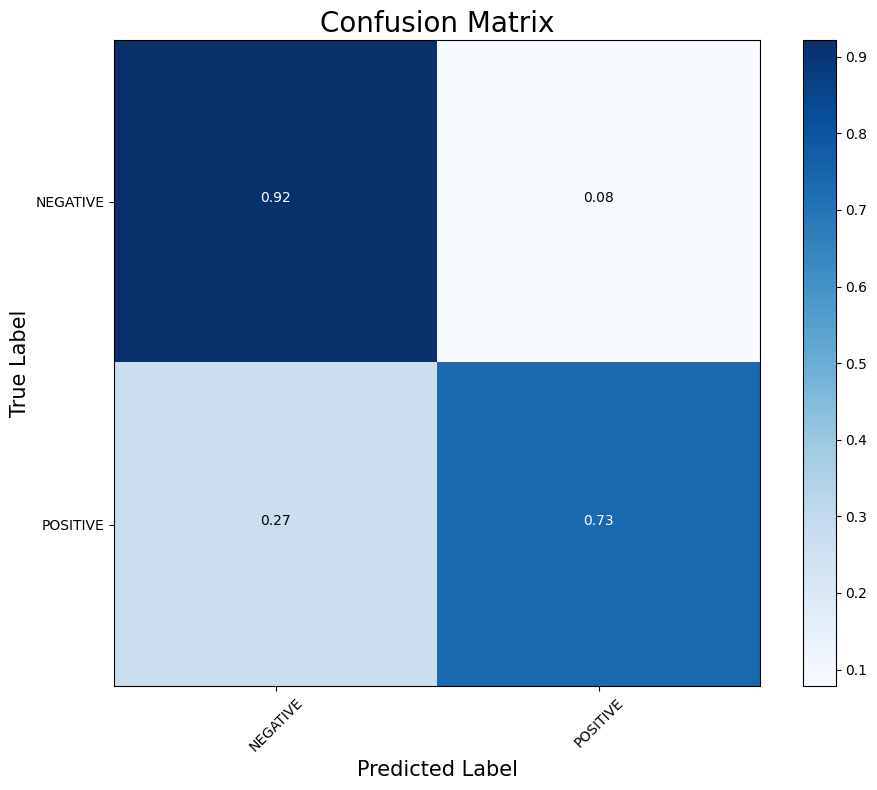

In [31]:
#this function takes the confusion matrix, class labels, and an optional title as input and generates a visual representation of the confusion matrix with labeled axes and color coding
def plot_confusion_matrix(confusion_matrix, class_labels, title='Confusion Matrix', cmap=plt.cm.Blues):
    normalized_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    fmt = '.2f'
    thresh = normalized_confusion_matrix.max() / 2.
    for i, j in itertools.product(range(normalized_confusion_matrix.shape[0]), range(normalized_confusion_matrix.shape[1])):
        plt.text(j, i, format(normalized_confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if normalized_confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.tight_layout()


#plot a confusion matrix using the provided class labels ("NEGATIVE" and "POSITIVE") and the confusion matrix computed from the model's predictions on the test dataset.
class_labels = ["NEGATIVE", "POSITIVE"]
conf_matrix = confusion_matrix(y_dataset_test, y_dataset_pred)
plot_confusion_matrix(conf_matrix, class_labels, title="Confusion Matrix")
plt.show()



##4.5 Report of Classification

In [32]:
from sklearn.metrics import classification_report

class_labels = ["NEGATIVE", "POSITIVE"]
report = classification_report(y_dataset_test, y_dataset_pred, target_names=class_labels)

print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.77      0.92      0.84      7055
    POSITIVE       0.90      0.73      0.81      7167

    accuracy                           0.83     14222
   macro avg       0.84      0.83      0.83     14222
weighted avg       0.84      0.83      0.83     14222



##4.6 Score of Accurancy

In [33]:
accuracy_score(y_dataset_test, y_dataset_pred)

0.8272394881170019

##4.7 Save The Bi-LSTM MODEL

In [34]:
# Save models and data using joblib
import joblib

# Variables for save the model
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

joblib.dump(bilstm_model, KERAS_MODEL)
joblib.dump(model_Word2Vec, WORD2VEC_MODEL)
joblib.dump(tokenizer, TOKENIZER_MODEL)
label_encoder
joblib.dump(label_encoder, ENCODER_MODEL)



['encoder.pkl']